In [ ]:

from examples import *
from pyVIA.core import *
import pandas as pd 
import umap 

dataset, ncomps, knn, seed Toy3 30 20 41


/home/shobi/anaconda3/envs/ViaEnv/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


root user ['M1']
true labels
2022-02-09 16:30:03.653651	Running VIA over input data of 1000 (samples) x 30 (features)
2022-02-09 16:30:03.774841	Global pruning of weighted knn graph


2022-02-09 16:30:03.933804	Finished global pruning. Kept 46.72 of edges. 
number of components in the original full graph 1
for downstream visualization purposes we are also constructing a low knn-graph 


size neighbor array in low-KNN in pca-space for visualization (1000, 4)
2022-02-09 16:30:04.319120	Commencing community detection
2022-02-09 16:30:04.351718	Finished running Leiden algorithm. Found 43 clusters.
2022-02-09 16:30:04.352225	No cluster is too big
before final small cluster handling we have 43 communities
2022-02-09 16:30:04.352393	Merging too small clusters (<10)
2022-02-09 16:30:04.353503	Finished detecting communities. Found 13 communities
2022-02-09 16:30:04.353848	Making cluster graph. Global cluster graph pruning level: 1
2022-02-09 16:30:04.357047	Graph has 1 connected components before pruning
root user ['M1']
new root is 3  with degree 9.38 M1
new root is 6  with degree 4.94 M1
2022-02-09 16:30:04.369570	Computing lazy-teleporting expected hitting times


ended all multiprocesses, will retrieve and reshape
closeness shortlist [3, 4, 6, 7, 8, 10]
betweeness shortlist [3, 4, 6, 7, 8, 9, 10]
out degree shortlist [3, 4, 6, 7, 8, 9]
original terminal clusters [4, 7, 8, 9, 10]
terminal clus in this component [4, 7, 8, 9, 10]
final terminal clus [4, 7, 8, 9, 10]


From root 6  to Terminal state 4 is found 68  times.


From root 6  to Terminal state 7 is found 307  times.


From root 6  to Terminal state 8 is found 180  times.


From root 6  to Terminal state 9 is found 199  times.


From root 6  to Terminal state 10 is found 311  times.
terminal clusters [4, 7, 8, 9, 10]
2022-02-09 16:30:05.791949	Begin projection of pseudotime and lineage likelihood


2022-02-09 16:30:05.927760	Graph has 1 connected components before pruning


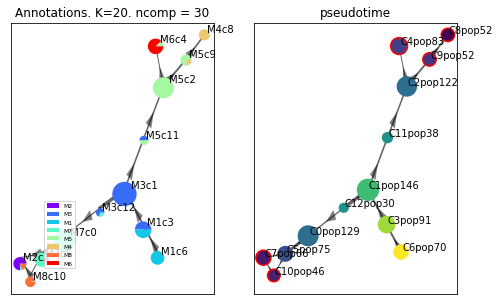

time elapsed 3.4 seconds


/home/shobi/anaconda3/envs/ViaEnv/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


shape before removing invalid cells
(1000, 2) (1000, 2)
shape after removing invalid cells
(1000, 2) (1000, 2)


super labels <class 'list'>
corr via knn 20 0.9337154319941827
Granular VIA iteration
true labels
2022-02-09 16:30:08.828601	Running VIA over input data of 1000 (samples) x 30 (features)
2022-02-09 16:30:08.952552	Global pruning of weighted knn graph


2022-02-09 16:30:09.007544	Finished global pruning. Kept 46.72 of edges. 
2022-02-09 16:30:09.007649	Commencing community detection
2022-02-09 16:30:09.040848	Finished running Leiden algorithm. Found 43 clusters.
2022-02-09 16:30:09.041193	Found 3 clusters that are too big
inside handle too big
2022-02-09 16:30:09.041312	Cluster 2 contains 117>100 samples and is too big
inside handle too big
2022-02-09 16:30:09.058731	Cluster 0 contains 125>100 samples and is too big
inside handle too big
2022-02-09 16:30:09.074814	Cluster 1 contains 124>100 samples and is too big
before final small cluster handling we have 56 communities
2022-02-09 16:30:09.090538	Merging too small clusters (<10)
2022-02-09 16:30:09.091749	Finished detecting communities. Found 24 communities
2022-02-09 16:30:09.092018	Making cluster graph. Global cluster graph pruning level: 1
2022-02-09 16:30:09.096677	Graph has 1 connected components before pruning
root user ['M1']
new root is 3  with degree 2.88 and super node degr

ended all multiprocesses, will retrieve and reshape
super_terminal_clusters [4, 7, 8, 9, 10]
terminal clus in this component [1, 4, 5, 6, 7]
final terminal clus [1, 4, 5, 6, 7]


From root 3  to Terminal state 1 is found 168  times.


From root 3  to Terminal state 4 is found 326  times.


From root 3  to Terminal state 5 is found 194  times.


From root 3  to Terminal state 6 is found 177  times.


From root 3  to Terminal state 7 is found 333  times.
terminal clusters [1, 4, 5, 6, 7]
2022-02-09 16:30:11.150952	Begin projection of pseudotime and lineage likelihood
2022-02-09 16:30:11.290630	Graph has 1 connected components before pruning
2022-02-09 16:30:11.293042	Graph has 1 connected components after reconnecting


/home/shobi/anaconda3/envs/ViaEnv/lib/python3.7/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


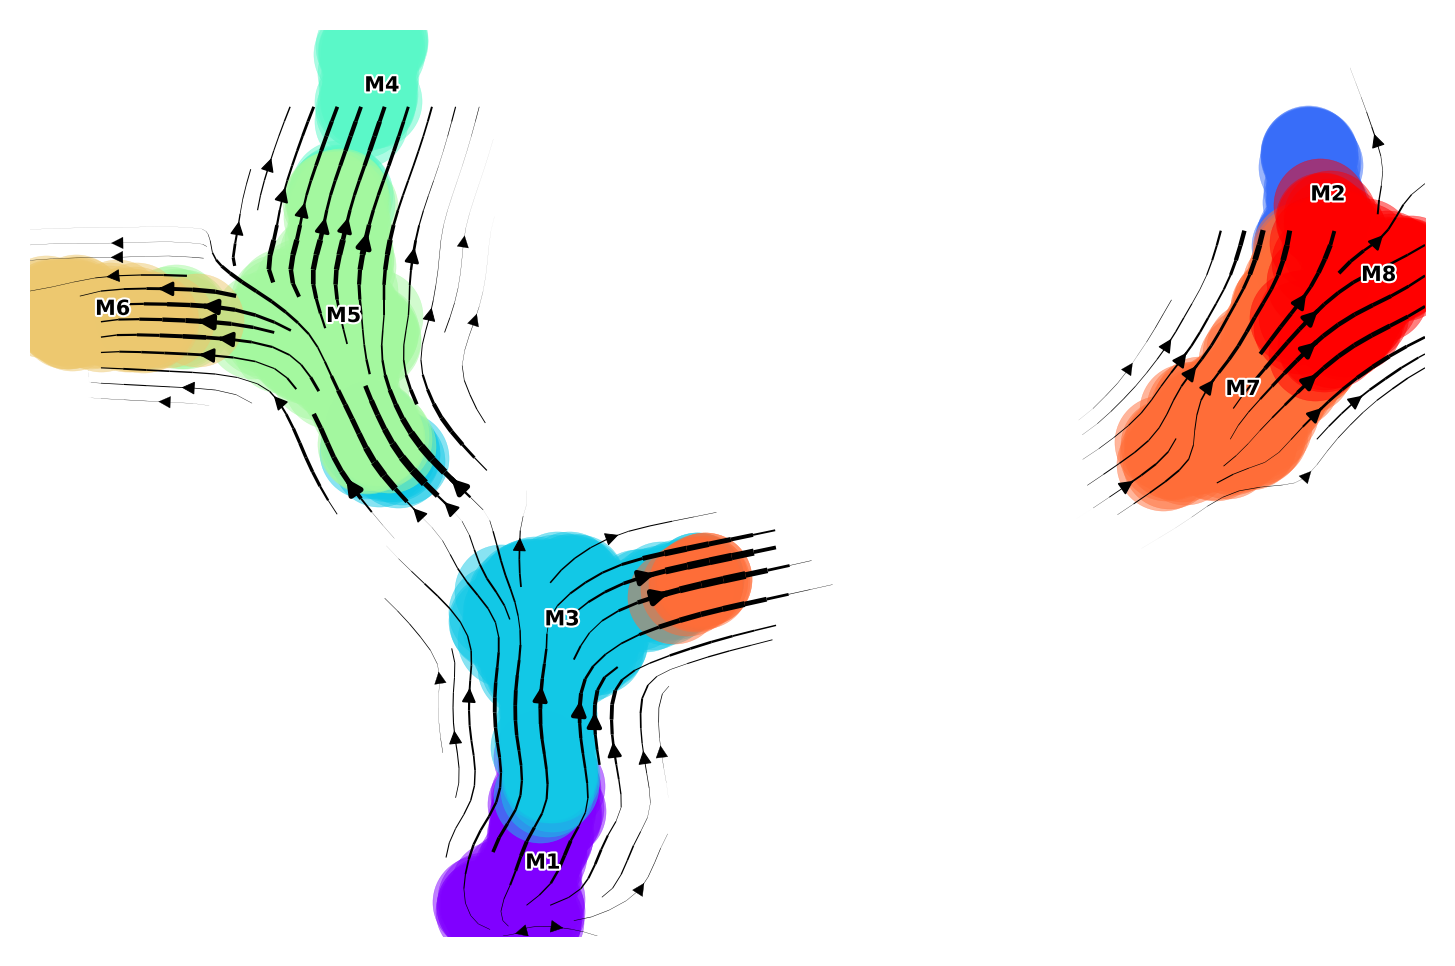

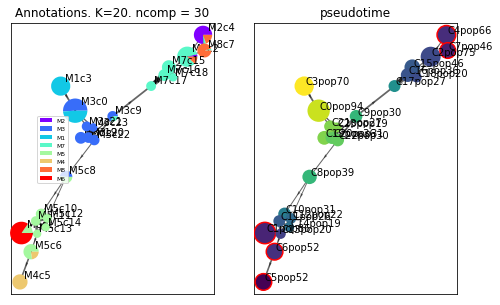

time elapsed 4.8 seconds
corr via knn 20 0.8964731817403772
len idx 1000
dict of terminal state pairs, Super: sub:  {4: 1, 7: 4, 8: 5, 9: 6, 10: 7}


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

super terminal and sub terminal False [1, 4, 5, 6, 7]


 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

super cluster 4 is a super terminal with sub_terminal cluster 1
super cluster 7 is a super terminal with sub_terminal cluster 4
super cluster 8 is a super terminal with sub_terminal cluster 5
super cluster 9 is a super terminal with sub_terminal cluster 6
super cluster 10 is a super terminal with sub_terminal cluster 7


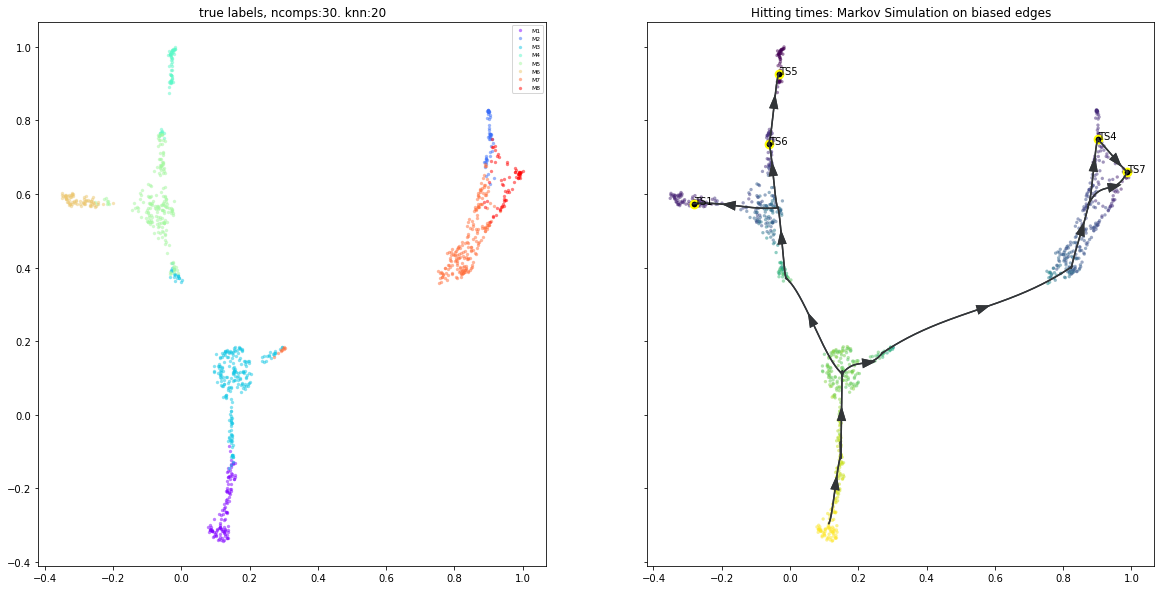

Cluster path on clustergraph starting from Root Cluster 3 to Terminal Cluster 1 : [3, 0, 21, 22, 8, 10, 11, 1]
Cluster path on clustergraph starting from Root Cluster 3 to Terminal Cluster 4 : [3, 0, 21, 20, 9, 17, 16, 2, 4]
Cluster path on clustergraph starting from Root Cluster 3 to Terminal Cluster 5 : [3, 0, 21, 22, 8, 12, 13, 6, 5]
Cluster path on clustergraph starting from Root Cluster 3 to Terminal Cluster 6 : [3, 0, 21, 22, 8, 12, 13, 6]
Cluster path on clustergraph starting from Root Cluster 3 to Terminal Cluster 7 : [3, 0, 21, 20, 9, 17, 16, 2, 7]
Cluster level path on sc-knnGraph from Root Cluster 3 to Terminal Cluster:  1 [3, 3, 0, 8, 1, 1, 1, 1, 1]
Cluster level path on sc-knnGraph from Root Cluster 3 to Terminal Cluster:  4 [3, 3, 0, 9, 2, 4, 4, 4, 4]
Cluster level path on sc-knnGraph from Root Cluster 3 to Terminal Cluster:  5 [3, 3, 0, 8, 14, 6, 5, 5, 5, 5, 5, 5]
Cluster level path on sc-knnGraph from Root Cluster 3 to Terminal Cluster:  6 [3, 3, 0, 8, 6, 6, 6]
Cluster 

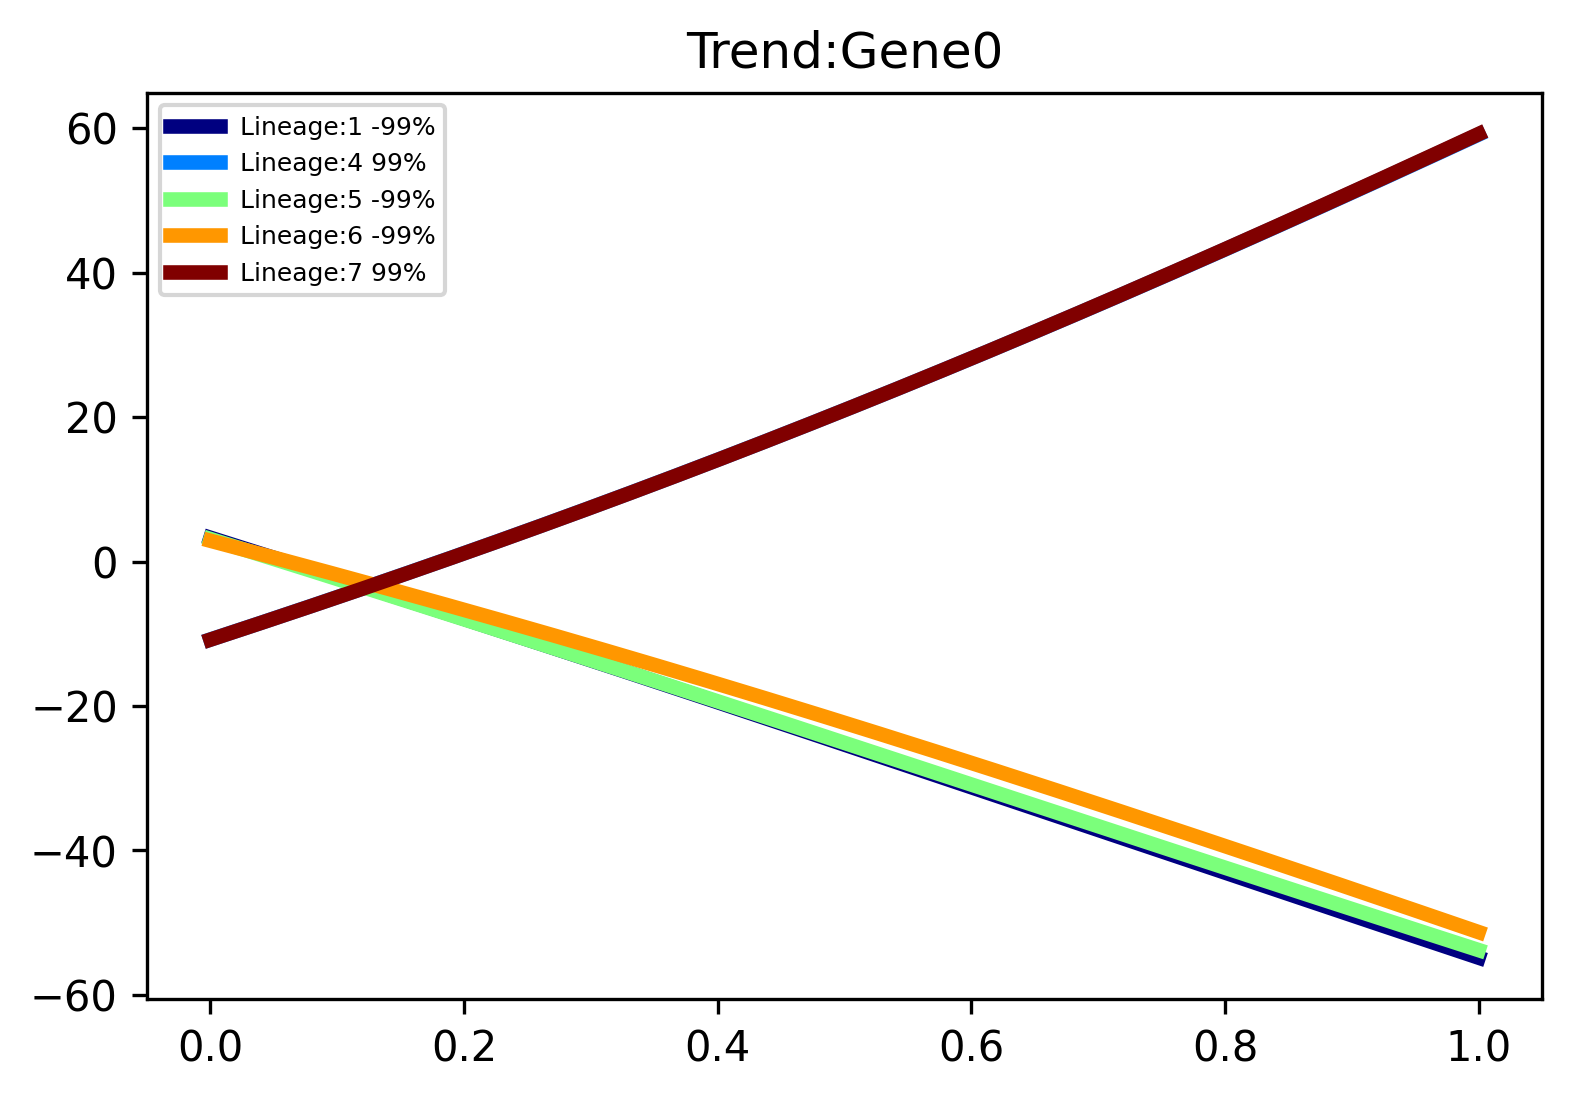

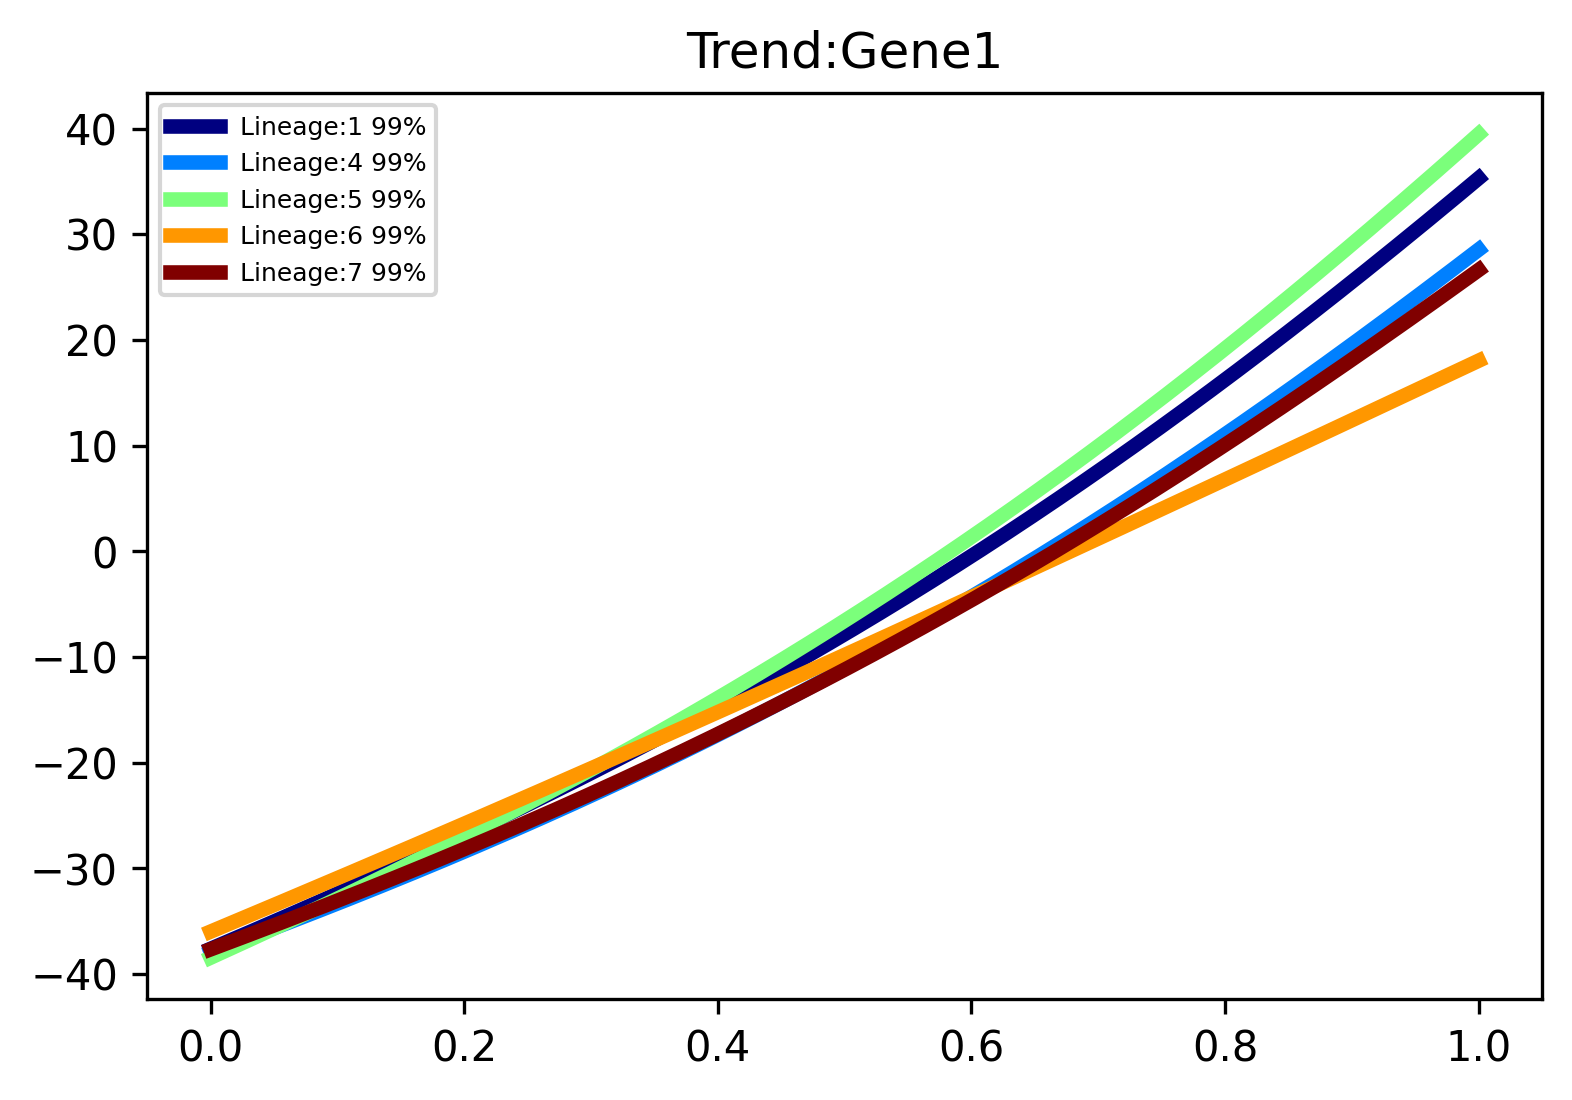

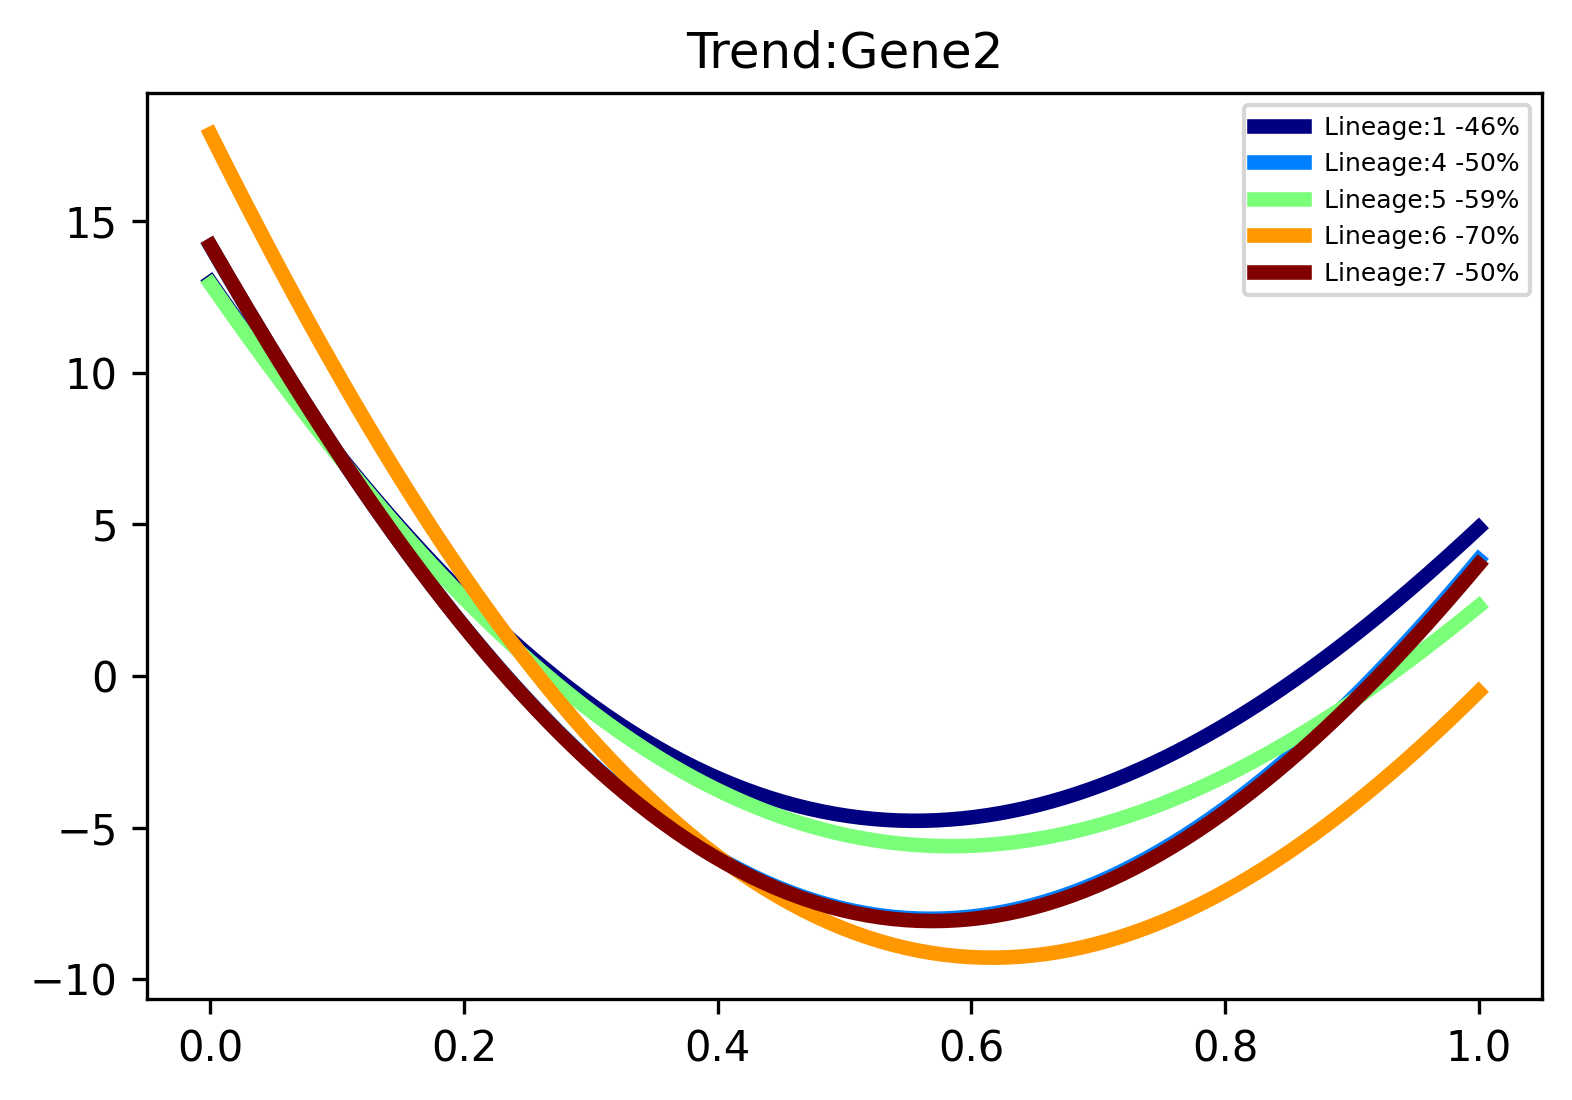

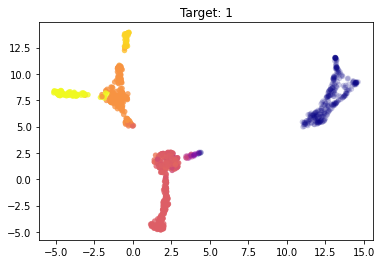

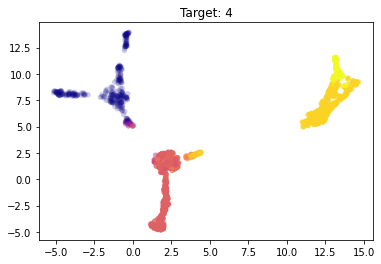

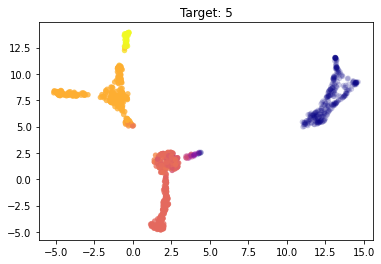

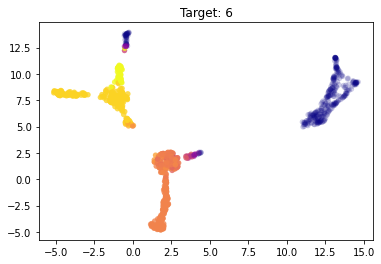

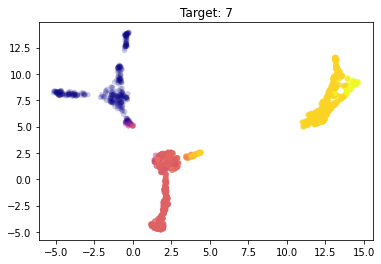

In [26]:
# Wrapper function that includes the various step-by-step blocks shown below 
# The wrapper shows the various types of outputs to be expected and can check your installation 
# Use the more detailed subsequent blocks of code to see how to run VIA 
main_Toy(ncomps=30, knn=20, random_seed=41, dataset='Toy3', foldername="/home/shobi/Trajectory/Datasets/Toy3/")

In [27]:
foldername="/home/shobi/Trajectory/Datasets/Toy3/"
df_counts = pd.read_csv(foldername + "toy_multifurcating_M8_n1000d1000.csv", delimiter=",")
df_ids = pd.read_csv(foldername + "toy_multifurcating_M8_n1000d1000_ids_with_truetime.csv", delimiter=",")

#define parameters
#for more generic purposes, dataset can be ='group' if root is a group level assignment corresponding to a group in true_label. or left as '', in which case root_user = [cell index] where cell index is an int
ncomps, knn, random_seed, dataset, root_user  =30,20, 41,'toy', ['M1']

#get the cell IDs and sort them to match the order or cell IDs in the df_counts file
df_ids['cell_id_num'] = [int(s[1::]) for s in df_ids['cell_id']]
df_counts = df_counts.drop('Unnamed: 0', 1)
df_ids = df_ids.sort_values(by=['cell_id_num'])
df_ids = df_ids.reset_index(drop=True)
true_label = df_ids['group_id'].tolist()
#true_time = df_ids['true_time'] #optional if one wants to do pseudotime correlation tests
#make anndata object with counts and group_ids 
adata_counts = sc.AnnData(df_counts, obs=df_ids)
sc.tl.pca(adata_counts, svd_solver='arpack', n_comps=ncomps)

embedding = umap.UMAP().fit_transform(adata_counts.obsm['X_pca'][:, 0:10])

/home/shobi/anaconda3/envs/ViaEnv/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


true labels
2022-02-09 16:19:21.769608	Running VIA over input data of 1000 (samples) x 30 (features)
2022-02-09 16:19:21.908030	Global pruning of weighted knn graph


2022-02-09 16:19:22.071155	Finished global pruning. Kept 46.72 of edges. 
number of components in the original full graph 1
for downstream visualization purposes we are also constructing a low knn-graph 


size neighbor array in low-KNN in pca-space for visualization (1000, 4)
2022-02-09 16:19:22.448657	Commencing community detection
2022-02-09 16:19:22.481134	Finished running Leiden algorithm. Found 43 clusters.
2022-02-09 16:19:22.481602	No cluster is too big
before final small cluster handling we have 43 communities
2022-02-09 16:19:22.481786	Merging too small clusters (<10)
2022-02-09 16:19:22.482863	Finished detecting communities. Found 13 communities
2022-02-09 16:19:22.483013	Making cluster graph. Global cluster graph pruning level: 1
2022-02-09 16:19:22.486132	Graph has 1 connected components before pruning
root user ['M1']
new root is 3  with degree 9.38 M1
new root is 6  with degree 4.94 M1
2022-02-09 16:19:22.498591	Computing lazy-teleporting expected hitting times


ended all multiprocesses, will retrieve and reshape
closeness shortlist [3, 4, 6, 7, 8, 10]
betweeness shortlist [3, 4, 6, 7, 8, 9, 10]
out degree shortlist [3, 4, 6, 7, 8, 9, 10]
original terminal clusters [4, 7, 8, 9, 10]
terminal clus in this component [4, 7, 8, 9, 10]
final terminal clus [4, 7, 8, 9, 10]


From root 6  to Terminal state 4 is found 68  times.


From root 6  to Terminal state 7 is found 307  times.


From root 6  to Terminal state 8 is found 180  times.


From root 6  to Terminal state 9 is found 199  times.


From root 6  to Terminal state 10 is found 311  times.
terminal clusters [4, 7, 8, 9, 10]
2022-02-09 16:19:23.872450	Begin projection of pseudotime and lineage likelihood


2022-02-09 16:19:24.005117	Graph has 1 connected components before pruning


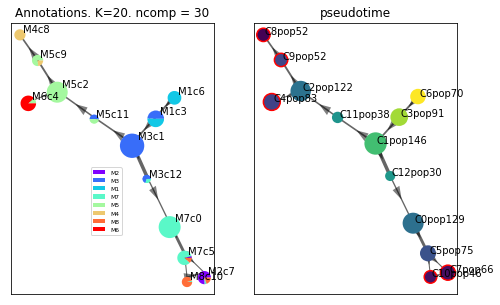

time elapsed 3.1 seconds


/home/shobi/anaconda3/envs/ViaEnv/lib/python3.7/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


shape before removing invalid cells
(1000, 2) (1000, 2)
shape after removing invalid cells
(1000, 2) (1000, 2)


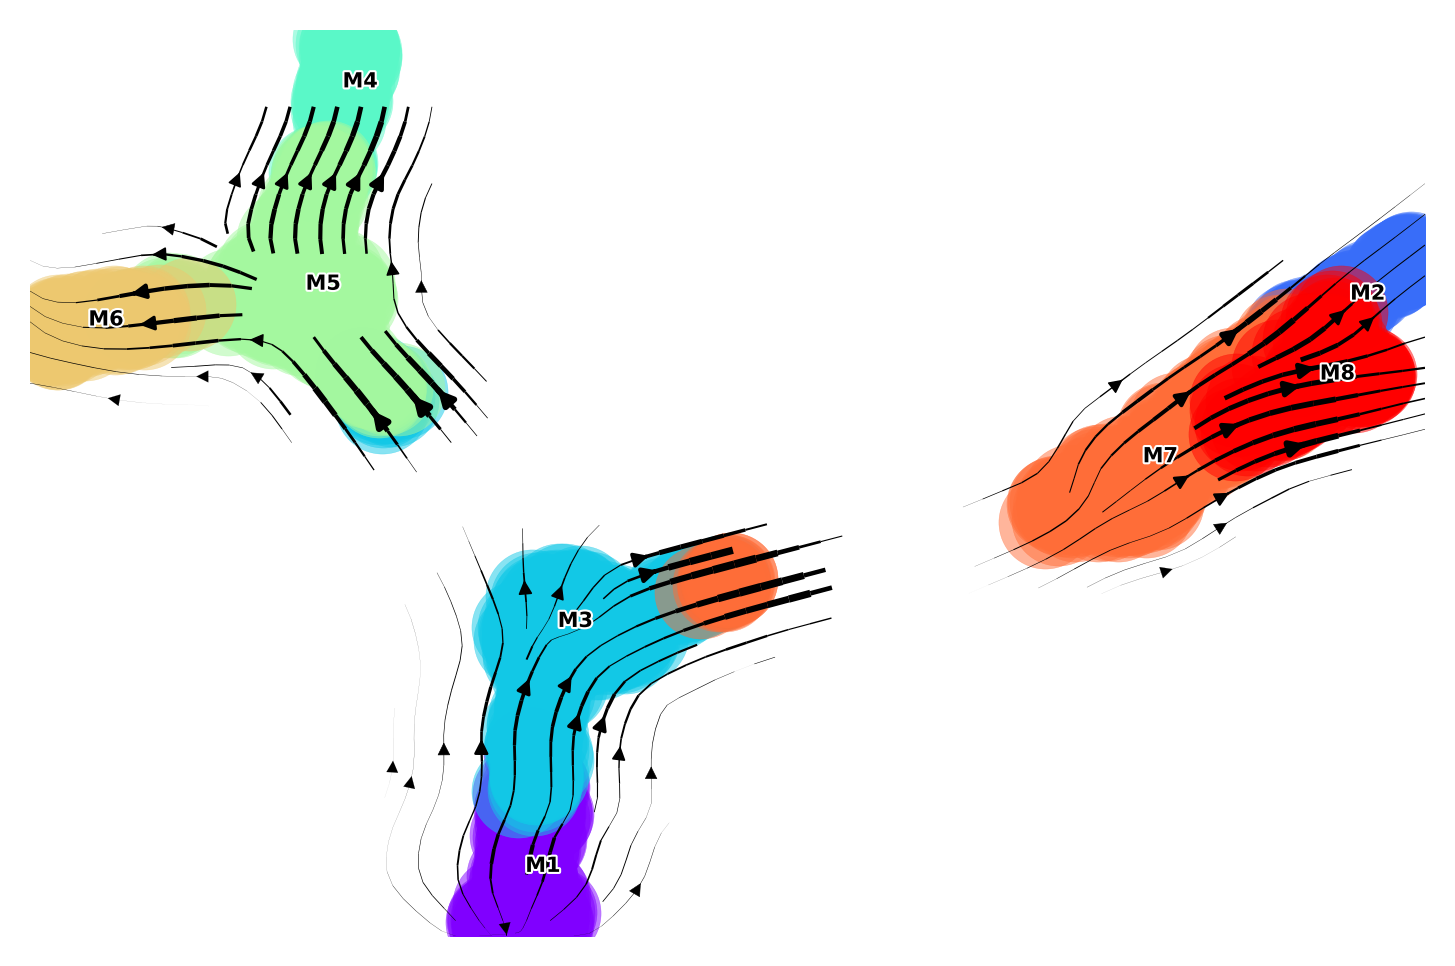

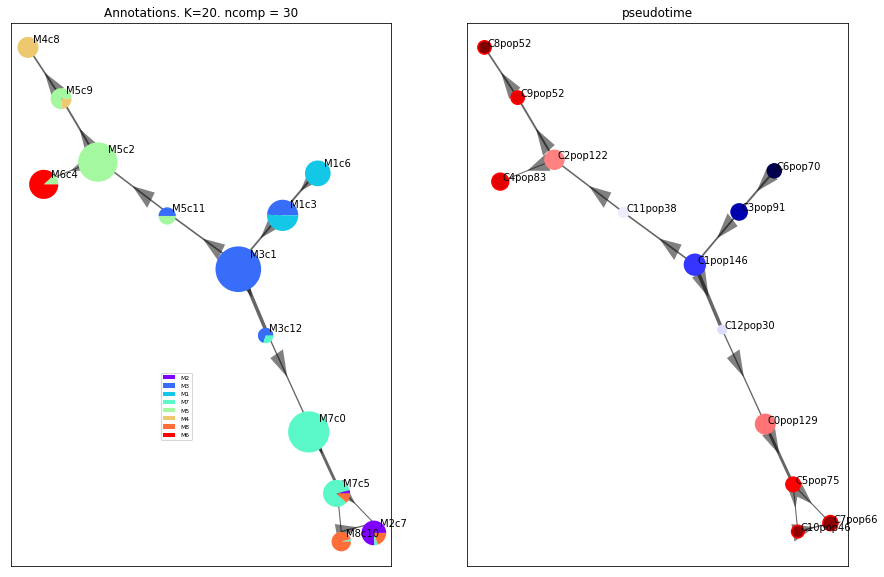

In [16]:
'''
# knn: number of nearest neighbors for the KNN-graph 
# clustergraph_pruning: typically 0-3, the number of standard deviations for clustergraph pruning. level of pruning applied to the clustergraph carried forward for pseudotime and lineage probability calculations. Larger means less pruning  
# true_label: list of annotations. if these are unavailable then leave as default None
# dist_std_local: local pruning on the singlecell graph used for clustering step, 1 is quite quite minimal level of pruning.  
# too_big_factor: default 0.3. Clusters that are bigger than 30% of the entire cell population will be re-clustered. If you only plan to do one iteration of VIA before visualizing TI, consider lowering this to 0.1-0.2.  
# preserve_disconnected: if you suspect disconnected trajectories, set this to False
# dataset = 'group': works for any dataset where the root is provided as a group ID in the true_label. e.g. if root = ['Day0'], then the root will be selected as a cluster which has root like properties and is largely made up of 'Day0' cells. 
            #If you wish to run a second finegrained iteration of VIA on a disconnected dataset, but uses the terminal clusters from the previous coarse run, then the dataset should be set as 'toy' and the true_labels formatted as "T1_M1" where Tx is the x'th component and My is the y'th cluster.
            # otherwise for disconnected datasets, you can just run a single iteration of VIA where you vary too_big_factor and other parameters to change granularity and set the dataset as '' or 'group' depending on the root_user type as [groupX, groupZ ...] or [cell indices...]  
            # dataset, can be left as default value '', but then the root must be a cell index corresponding to a best guess. 
# root_user =['M1']
# visual_cluster_graph_pruning: this impacts the level of pruning done to the clustergraph before visualization. Does not impact underlying computations  
# Max_visual_outgoing_edges: controls number of edges extending from each node
'''

v0 = VIA(adata_counts.obsm['X_pca'][:, 0:ncomps], true_label, jac_std_global=0.15, dist_std_local=1,
             knn=knn,
             cluster_graph_pruning_std=1,
             too_big_factor=0.3, root_user=root_user, preserve_disconnected=True, dataset='group',
             visual_cluster_graph_pruning=1, max_visual_outgoing_edges=2,
             random_seed=random_seed, piegraph_arrow_head_width=0.2,
             piegraph_edgeweight_scalingfactor=1.0)  
v0.run_VIA()
v0.via_streamplot(embedding)

# draw the piechart clustergraph beside a clustergraph colored by the pseudotime ('pt') or gene expression ('gene').
# type_pt: 'pt' automatically takes the cluster level pseudotimes. 'gene' requires user to also pass gene_exp 
# gene_exp =''. In order to plot gene intensity, a list of cluster level gene/feature values should be provided
# cmap = None. Can be specified and influences the cmap of the pt/gene graph
# ax_text = True. Can set to false if you don't want the cluster and populations labels 
f, ((ax0, ax1)) = plt.subplots(1, 2, sharey=True, figsize=[15, 10])  
v0.draw_piechart_graph(ax0, ax1, type_pt='pt', title='Toy multifurcation', cmap='seismic', ax_text=True, gene_exp='')
plt.show()

dict of terminal state pairs, Super: sub:  {}


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:  00:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

super cluster 4 is a super terminal with sub_terminal cluster 4
super cluster 7 is a super terminal with sub_terminal cluster 7
super cluster 8 is a super terminal with sub_terminal cluster 8
super cluster 9 is a super terminal with sub_terminal cluster 9
super cluster 10 is a super terminal with sub_terminal cluster 10
Cluster path on clustergraph starting from Root Cluster 6 to Terminal Cluster 4 : [6, 3, 1, 11, 2, 4]
Cluster path on clustergraph starting from Root Cluster 6 to Terminal Cluster 7 : [6, 3, 1, 12, 0, 5, 7]
Cluster path on clustergraph starting from Root Cluster 6 to Terminal Cluster 8 : [6, 3, 1, 11, 2, 9, 8]
Cluster path on clustergraph starting from Root Cluster 6 to Terminal Cluster 9 : [6, 3, 1, 11, 2, 9]
Cluster path on clustergraph starting from Root Cluster 6 to Terminal Cluster 10 : [6, 3, 1, 12, 0, 5, 10]
Cluster level path on sc-knnGraph from Root Cluster 6 to Terminal Cluster:  4 [6, 6, 6, 3, 1, 11, 2, 4, 4, 4]
Cluster level path on sc-knnGraph from Root Clu

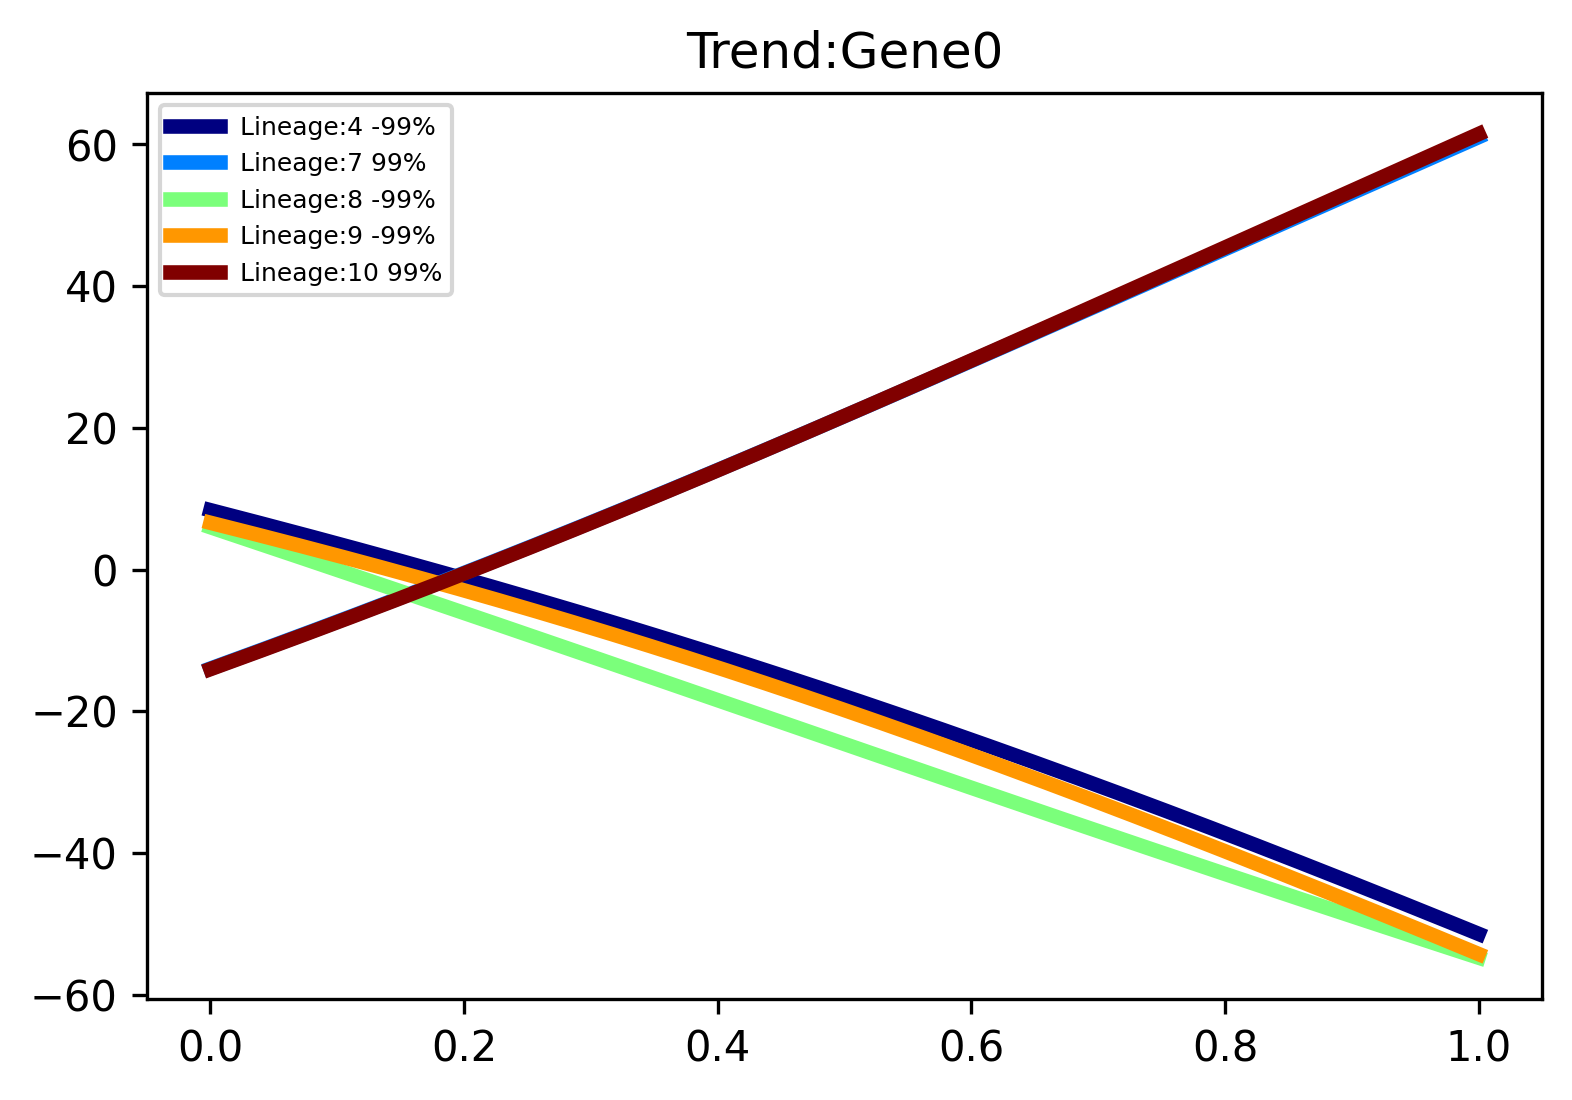

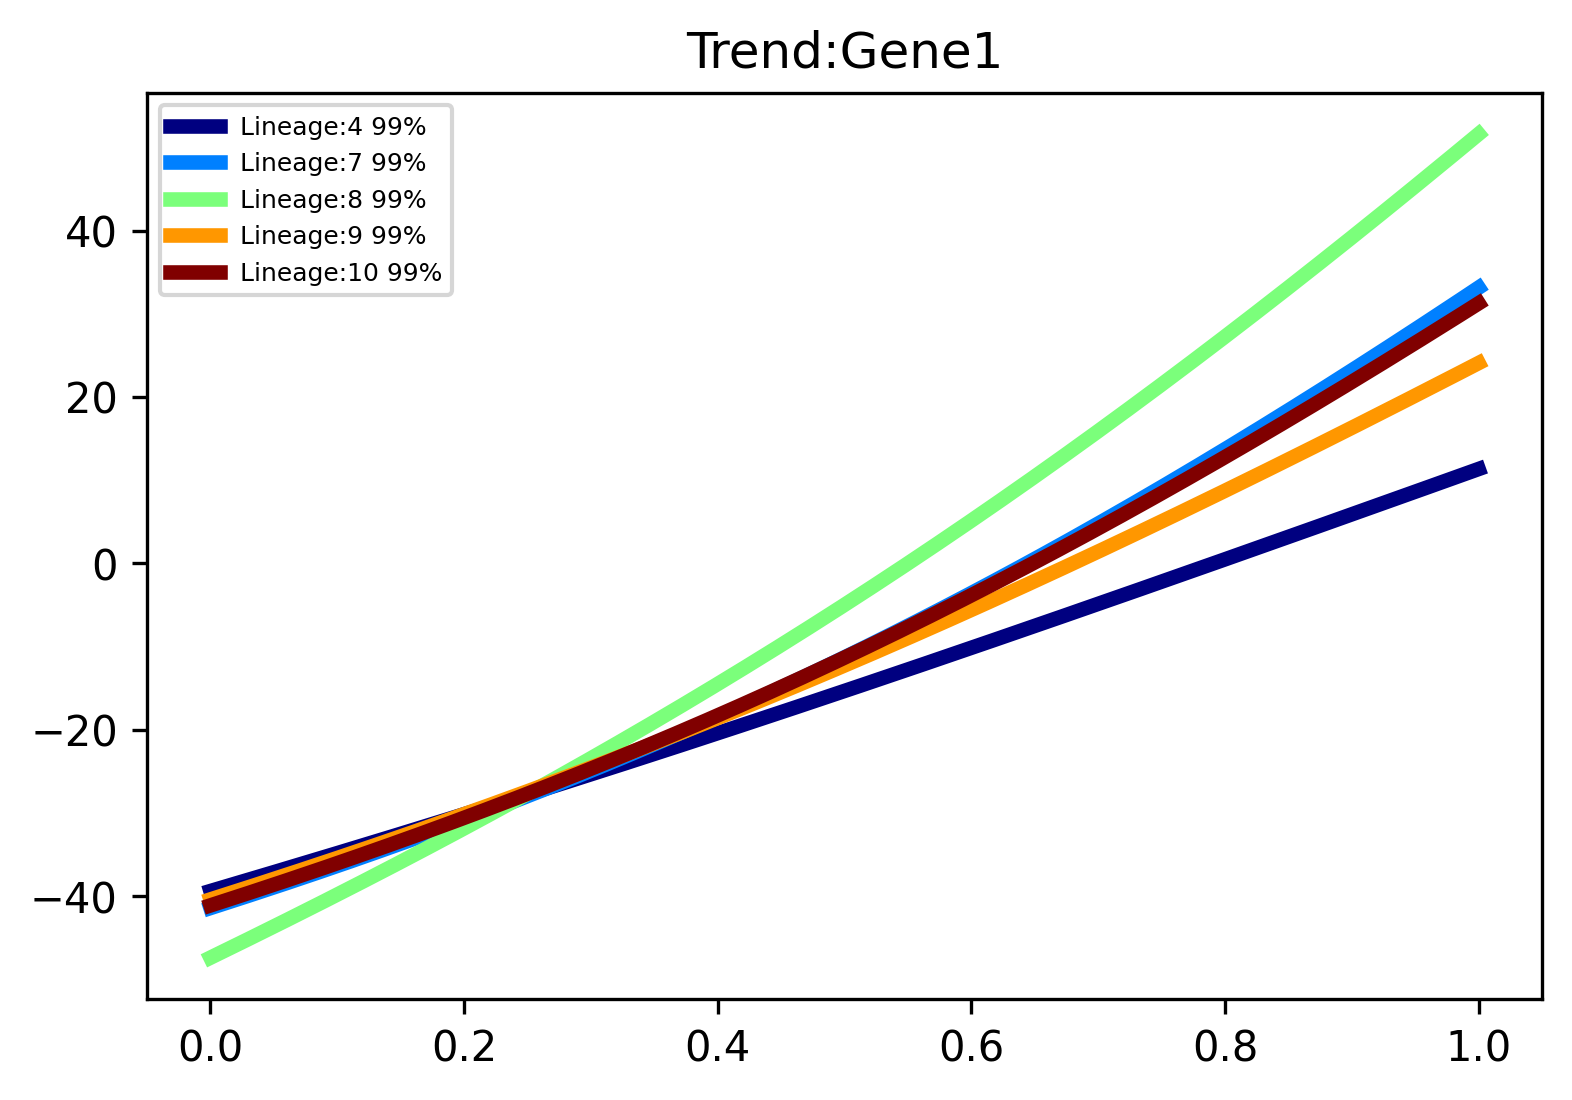

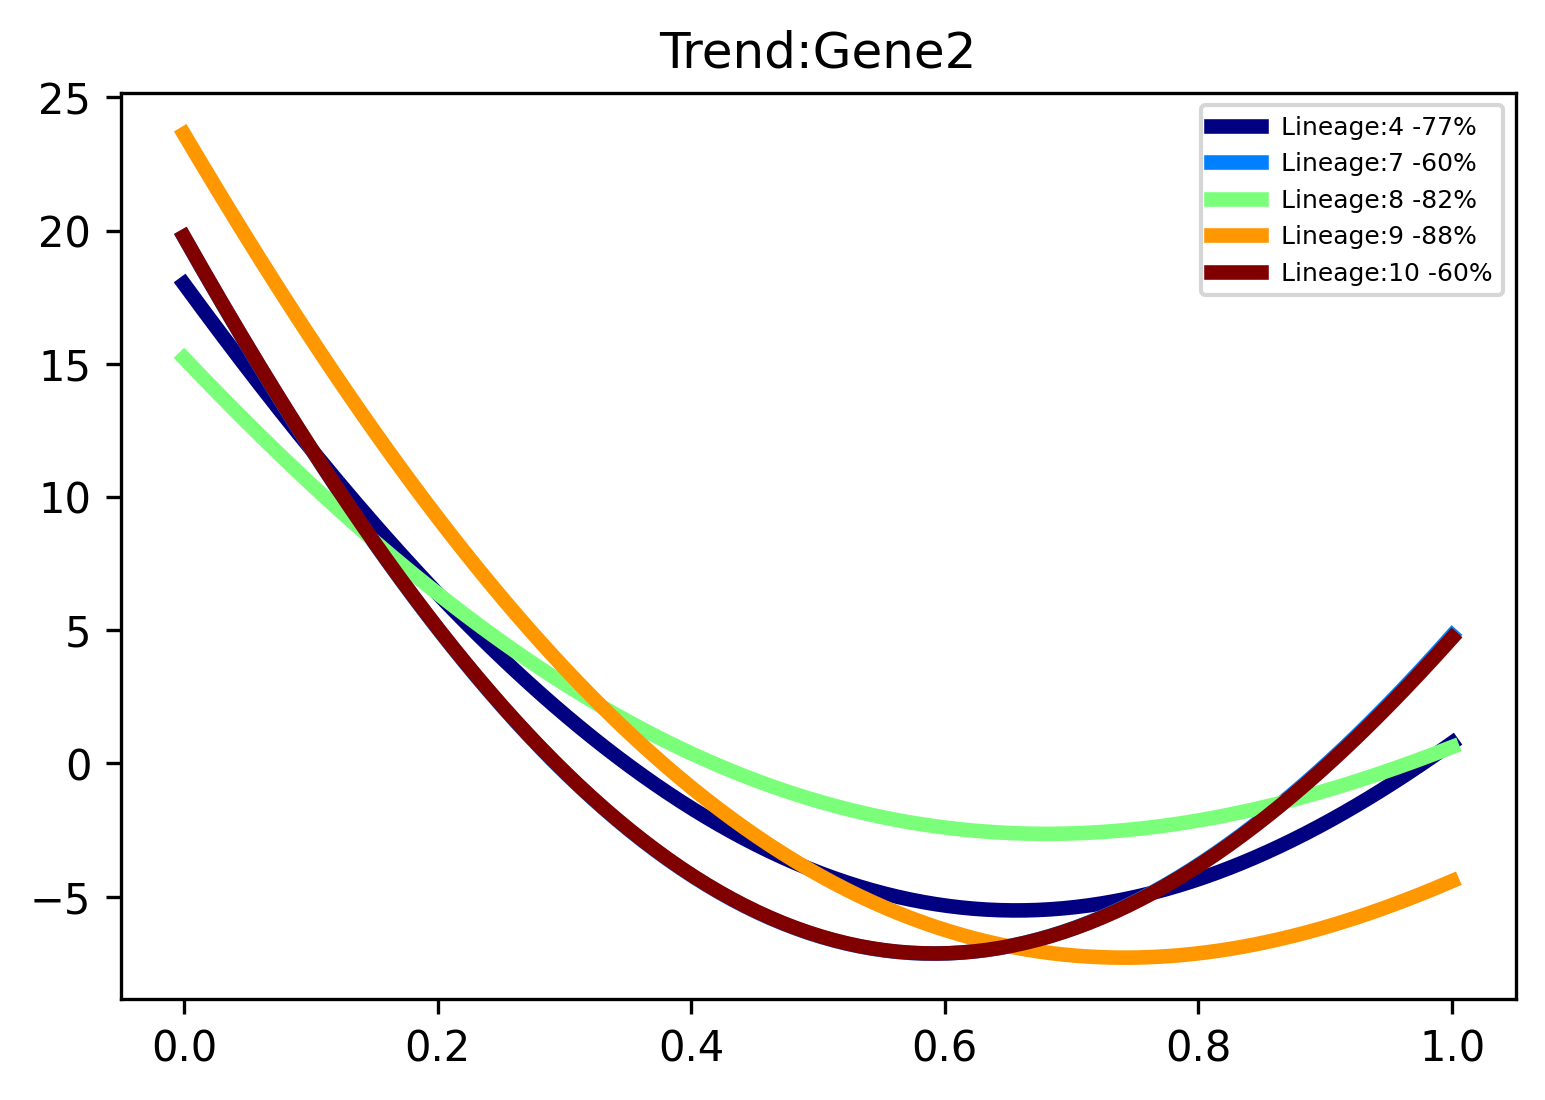

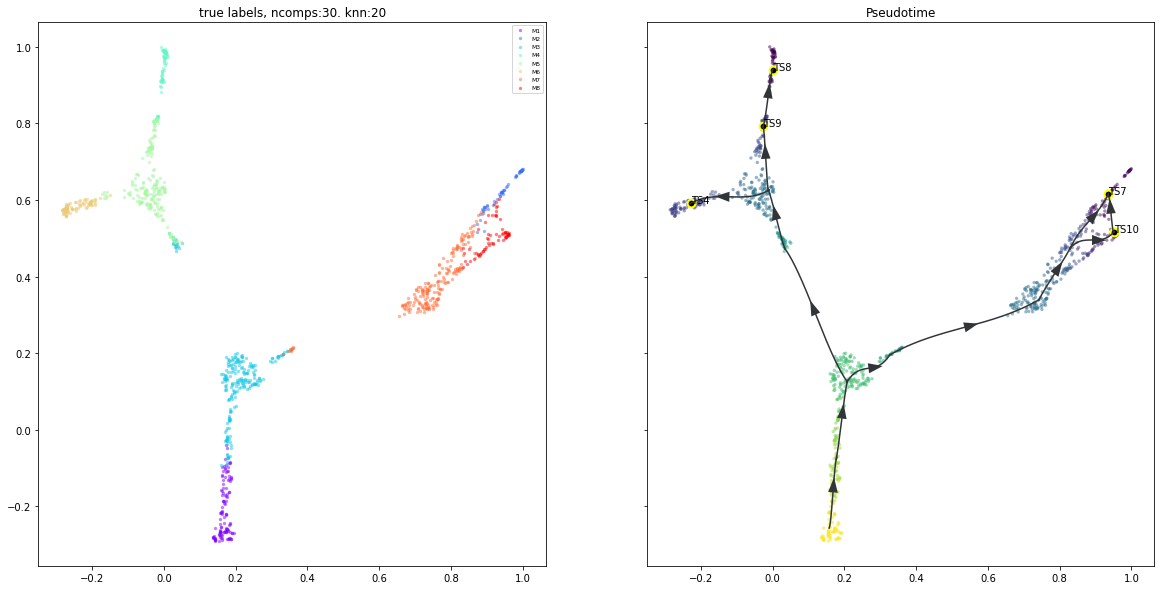

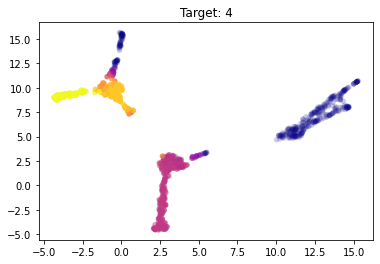

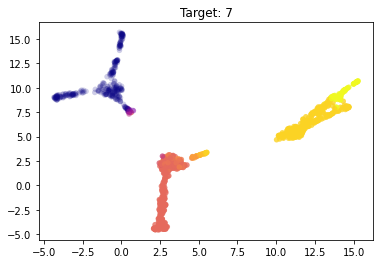

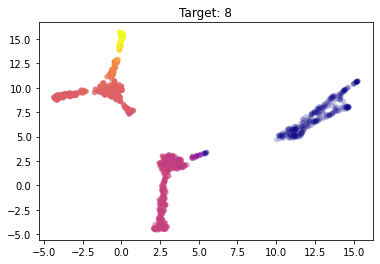

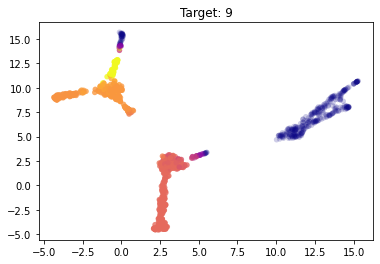

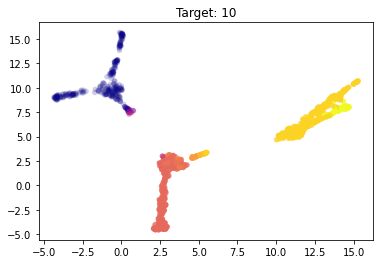

In [17]:

df_subset = pd.DataFrame(adata_counts.obsm['X_pca'][:, 0:5], columns=['Gene0', 'Gene1', 'Gene2', 'Gene3', 'Gene4'])
for gene_i in ['Gene0', 'Gene1', 'Gene2']:  
    subset_ = df_subset[gene_i].values
    v0.get_gene_expression(subset_, title_gene=gene_i, verbose=False)


knn_hnsw = make_knn_embeddedspace(embedding)
super_clus_ds_PCA_loc = sc_loc_ofsuperCluster_PCAspace(v0, v0, np.arange(0, len(v0.labels)))
# draw overall pseudotime and main trajectories
draw_trajectory_gams(embedding, super_clus_ds_PCA_loc, v0.labels, v0.labels, v0.edgelist_maxout,
                     v0.x_lazy, v0.alpha_teleport, v0.single_cell_pt_markov, true_label, knn=v0.knn,
                     final_super_terminal=v0.terminal_clusters,
                     sub_terminal_clusters=v0.terminal_clusters,
                     title_str='Pseudotime', ncomp=ncomps)

idx = np.arange(0, len(v0.labels))
draw_sc_evolution_trajectory_dijkstra(v0, embedding, make_knn_embeddedspace(embedding), v0.full_graph_shortpath, idx)

plt.show()

Wed Feb  9 16:20:44 2022 Correlation between VIA pseudotime and "temporal annotations 94.0 %
true labels
2022-02-09 16:20:44.855214	Running VIA over input data of 1000 (samples) x 30 (features)
2022-02-09 16:20:44.982409	Global pruning of weighted knn graph
2022-02-09 16:20:45.024225	Finished global pruning. Kept 46.72 of edges. 
2022-02-09 16:20:45.024331	Commencing community detection


2022-02-09 16:20:45.057220	Finished running Leiden algorithm. Found 43 clusters.
2022-02-09 16:20:45.057608	Found 3 clusters that are too big
inside handle too big
2022-02-09 16:20:45.057678	Cluster 2 contains 117>100 samples and is too big
inside handle too big
2022-02-09 16:20:45.071673	Cluster 0 contains 125>100 samples and is too big
inside handle too big
2022-02-09 16:20:45.086678	Cluster 1 contains 124>100 samples and is too big
before final small cluster handling we have 56 communities
2022-02-09 16:20:45.101153	Merging too small clusters (<10)
2022-02-09 16:20:45.102567	Finished detecting communities. Found 24 communities
2022-02-09 16:20:45.102717	Making cluster graph. Global cluster graph pruning level: 1
2022-02-09 16:20:45.107408	Graph has 1 connected components before pruning
root user ['M1']
new root is 3  with degree 2.88 and super node degree 4.94
2022-02-09 16:20:45.122270	Computing lazy-teleporting expected hitting times


ended all multiprocesses, will retrieve and reshape
super_terminal_clusters [4, 7, 8, 9, 10]
terminal clus in this component [1, 4, 5, 6, 7]
final terminal clus [1, 4, 5, 6, 7]


From root 3  to Terminal state 1 is found 187  times.


From root 3  to Terminal state 4 is found 308  times.


From root 3  to Terminal state 5 is found 176  times.


From root 3  to Terminal state 6 is found 174  times.


From root 3  to Terminal state 7 is found 315  times.
terminal clusters [1, 4, 5, 6, 7]
2022-02-09 16:20:47.271443	Begin projection of pseudotime and lineage likelihood
2022-02-09 16:20:47.431538	Graph has 1 connected components before pruning


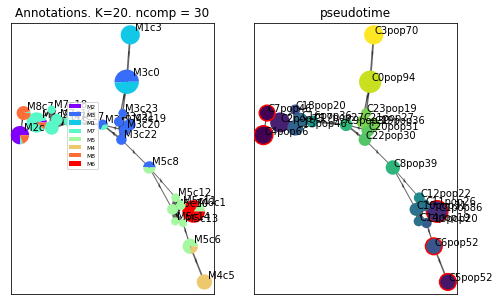

time elapsed 4.4 seconds
Wed Feb  9 16:20:49 2022 Correlation between VIA pseudotime and "temporal annotations 91.0 %


In [19]:
super_labels = v0.labels
df_ids['pt'] = v0.single_cell_pt_markov
correlation = df_ids['pt'].corr(df_ids['true_time'])
print(time.ctime(),'Correlation between VIA pseudotime and "temporal annotations', round(correlation,2)*100,'%')
super_edges = v0.edgelist
tsi_list = get_loc_terminal_states(via0=v0, X_input=adata_counts.obsm['X_pca'][:, 0:ncomps])


v1 = VIA(adata_counts.obsm['X_pca'][:, 0:ncomps], true_label, jac_std_global=0.15, dist_std_local=1,
             knn=knn,
             too_big_factor=0.1,
             cluster_graph_pruning_std=1,
             super_cluster_labels=super_labels, super_node_degree_list=v0.node_degree_list,
             super_terminal_cells=tsi_list, root_user=root_user, is_coarse=False,
             x_lazy=0.95, alpha_teleport=0.99, preserve_disconnected=True, dataset='group',
             visual_cluster_graph_pruning=1, max_visual_outgoing_edges=2,
             super_terminal_clusters=v0.terminal_clusters,
             full_neighbor_array=v0.full_neighbor_array,
             ig_full_graph=v0.ig_full_graph, full_distance_array=v0.full_distance_array,
             csr_array_locally_pruned=v0.csr_array_locally_pruned, random_seed=random_seed)  # root=1,

v1.run_VIA()
labels = v1.labels
df_ids['pt1'] = v1.single_cell_pt_markov
correlation = df_ids['pt1'].corr(df_ids['true_time'])
print(time.ctime(),'Correlation between VIA pseudotime and "temporal annotations', round(correlation,2)*100,'%')

len idx 1000
dict of terminal state pairs, Super: sub:  {4: 1, 7: 4, 8: 5, 9: 6, 10: 7}


N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

super terminal and sub terminal False [1, 4, 5, 6, 7]


 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:  00:00:00

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 36% (4 of 11) |#########                | Elapsed Time: 0:00:00 ETA:   0:00:00

 54% (6 of 11) |#############            | Elapsed Time: 0:00:00 ETA:   0:00:00

 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00

 90% (10 of 11) |#####################   | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:  00:00:00

 45% (5 of 11) |###########              | Elapsed Time: 0:00:00 ETA:   0:00:00

 63% (7 of 11) |###############          | Elapsed Time: 0:00:00 ETA:   0:00:00

 81% (9 of 11) |####################     | Elapsed Time: 0:00:00 ETA:   0:00:00

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00

super cluster 4 is a super terminal with sub_terminal cluster 1
super cluster 7 is a super terminal with sub_terminal cluster 4
super cluster 8 is a super terminal with sub_terminal cluster 5
super cluster 9 is a super terminal with sub_terminal cluster 6
super cluster 10 is a super terminal with sub_terminal cluster 7


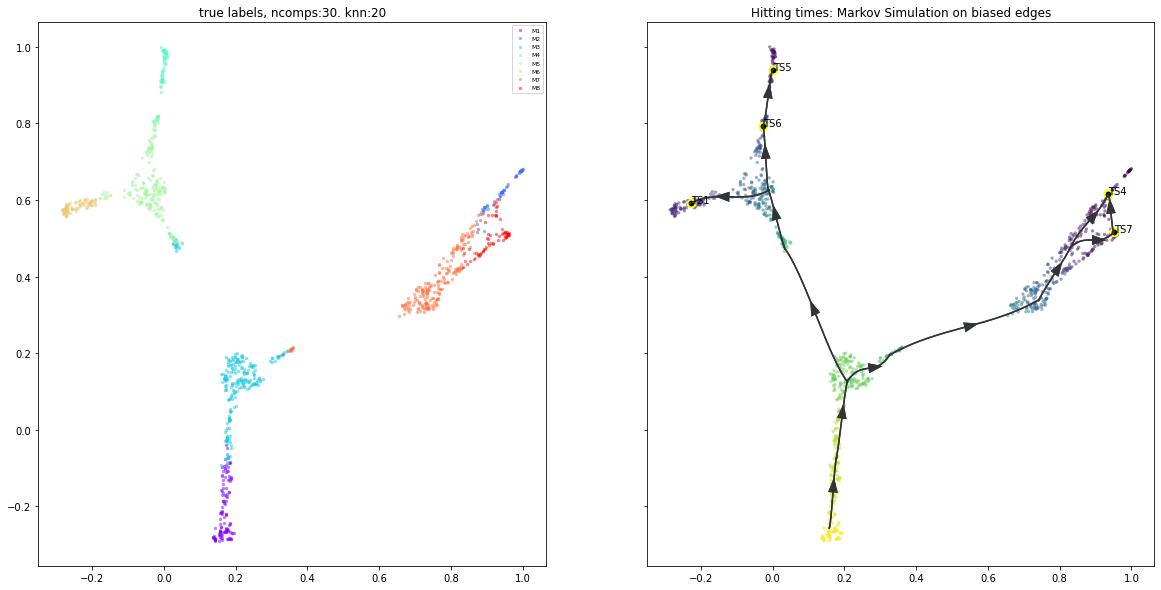

In [20]:
n_downsample = 50
if len(labels) > n_downsample:  # just testing the downsampling and indices. Not actually downsampling
    np.random.seed(2357)
    idx = np.random.choice(a=np.arange(0, len(labels)), size=len(labels), replace=False, p=None)
    super_labels = np.asarray(super_labels)[idx]
    labels = list(np.asarray(labels)[idx])
    true_label = list(np.asarray(true_label)[idx])
    sc_pt_markov = list(np.asarray(v1.single_cell_pt_markov[idx]))

super_clus_ds_PCA_loc = sc_loc_ofsuperCluster_PCAspace(v0, v1, idx)
print('super terminal and sub terminal', v0.super_terminal_cells, v1.terminal_clusters)

draw_trajectory_gams(embedding, super_clus_ds_PCA_loc, labels, super_labels, super_edges,
                     v1.x_lazy, v1.alpha_teleport, sc_pt_markov, true_label, knn=v0.knn,
                     final_super_terminal=v1.revised_super_terminal_clusters,
                     sub_terminal_clusters=v1.terminal_clusters,
                     title_str='Hitting times: Markov Simulation on biased edges', ncomp=ncomps)
plt.show()
